# Hughes, et al
The following notebook contains the code necessary for replicating the RNA-seq analysis performed in the publication.   
   
<b>Read Processing</b>:   
<u>Sequencing</u>: Samples were sequenced at the University of Utah High-Throughtput Sequencing Core
<u>Bioinformatics</u>: Raw counts files were processed by the University of Utah Bioinformatics Core  
<u>Data</u>: Raw data contained within this repository is the property of the Adam Hughes lab at the University of Utah

### File path   
Users of this notebook should modify the path to specify the absolute path where this repository is downloaded   
path string must end with '/'

In [1]:
import os 
__path__  =  os.path.dirname(os.path.realpath('./')) + '/hughes_rnaseq_2019/'

In [2]:
__path__  =  '/Users/jordan/Desktop/collaborations/casey_collab/'

### Import dependencies and file path    
<b><a href='https://doi.org/10.5281/zenodo.3226973'>XPRESSplot</a></b> is part of the <b><a href='https://github.com/XPRESSyourself'>XPRESSyourself</a></b> bioinformatics suite under development by Jordan A. Berg   

In [3]:
%%capture 
# Hide matplotlib backend error

import pandas as pd 
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import xpressplot as xp

### Import raw read counts files and tabulate, normalize, and rename gene names

<b><u>Code Block #1</u></b>
1. File names are collected   
2. The first file is read into a dataframe with metadata   
3. Each subsequent file's count column is added column-wise to the dataframe   
4. File names are modified to remove file extension

In [4]:
#Get file names
file_list = []
for subdir, dirs, files in os.walk(str(__path__ + 'raw_data/')):
    for d in dirs:
        for subdir, dirs, files in os.walk(__path__ + 'raw_data/' + d):
            for f in files:
                if f.endswith('.counts'):
                    file_list.append(__path__ + 'raw_data/' + d + '/' + f)
                else:
                    pass
                
#Read in first file                
df = pd.read_csv(str(file_list[0]), sep='\t', comment='#') 
pos_starter = [0,5,6]
colname = df.columns[pos_starter]

df = df[colname]

#Read in remaining files
for f in file_list[1:]:
    df_pull = pd.read_csv(str(f), sep='\t', comment='#')
    df = pd.concat([df, df_pull[df_pull.columns[6]]], axis=1)
    del df_pull
    
#Modify sample names in dataframe
df.columns = df.columns.str.replace(".bam", "")

<b><u>Code Block #2</u></b>   
5. Remove gene lengths from count dataframe
6. Create reference dataframe with gene names and gene lengths for downstream use

In [5]:
#Create counts table
df_counts = df.copy()
df_counts = df_counts.drop(labels='Length', axis=1)
df_counts = df_counts.set_index('Geneid')
del df_counts.index.name

#Create gene length reference for downstream RPKM normalization
df_length = df.copy()
df_length = df_length.loc[:, 'Geneid':'Length']
df_length = df_length.set_index('Geneid')
del df_length.index.name

<b><u>Code Block #3</u></b>   
7. Perform RPKM normalization on count dataframe

In [6]:
#Perform RPKM normalization using gene length reference
df_rpm = df_counts / (df_counts.sum() / 1e6)
df_rpkm = df_rpm.div(df_length.Length, axis=0)
df_rpkm = df_rpkm.dropna(axis=0)

#Print some info
print('Shape before normalization: ' + str(df_counts.shape))
print('Shape after normalization: ' + str(df_rpkm.shape))

Shape before normalization: (6219, 12)
Shape after normalization: (6219, 12)


<b><u>Code Block #6</u></b>   
11. Import RNAseq metadata needed for later analysis   
12. Create a samples color palette 

In [7]:
#Import file with metadata
info = pd.read_csv(__path__ + 'metadata/info_table.csv', header=None)
info_original = info

#Combine labels
info[1] = info[1] + '_time' + info[2].astype(str) + "_rep" + info[3]

#Keep relevant metadata
info_pos = [0,1]
info_colname = info.columns[info_pos]
info = info[info_colname]

#Get list of merged samples names
info_original[1] = info_original[2]
info_ch = info_original[[0,1]]
conA = list(info[1])[0:12]

#Create a samples color dictionary for plots
colors = {
    '0 hr Concanamycin A':'#d0fefe',
    '1 hr Concanamycin A':'#a2cffe',
    '3 hr Concanamycin A':'#047495',
    '6 hr Concanamycin A':'#1f3b4d'}

<b><u>Code Block #7</u></b> 
13. Order columns of dataframe

In [8]:
#Specify column order for dataframe
col_order = [
    '14517X1',
     '14517X2',
     '14517X3',
     '14517X4',
     '14517X5',
     '14517X6',
     '14517X7',
     '14517X8',
     '14517X9',
     '14517X10',
     '14517X11',
     '14517X12']

df_conA_sort = df_rpkm.reindex(col_order, axis=1)

<b><u>Code Block #8</u></b> 
14. Export counts and RPKM tables

In [9]:
#Output counts tables for each dataset (no renaming of genes)
df_counts.to_csv(__path__ + 'processed_data/conA_counts.csv')
df_rpkm.to_csv(__path__ + 'processed_data/conA_rpkm.csv')

<b><u>Code Block #9</u></b>   
15. Scale genes for heatmaps (mean=0, stdev=1 per gene) 

In [10]:
#Scale gene rows
df_conA_scaled = df_conA_sort.copy()
df_conA_scaled = df_conA_scaled.dropna()
df_conA_scaled[df_conA_scaled.columns] = preprocessing.scale(df_conA_scaled[df_conA_scaled.columns], axis=1)

#Print some info        
print('Dataframe size before scaling: ' + str(df_conA_sort.shape))
print('Dataframe size after scaling: ' + str(df_conA_scaled.shape))

Dataframe size before scaling: (6219, 12)
Dataframe size after scaling: (6219, 12)


### Oxidative Stress Gene List Heatmap

Size of gene cohort data matrix:(20, 12)


<Figure size 432x288 with 0 Axes>

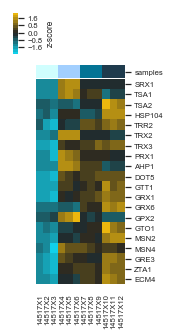

In [11]:
#Get genes of interest for heatmap
genes = pd.read_csv(__path__ + 'metadata/oxidative_stress_genes.csv')
genes_dict = genes[['ORF','Gene name']]
genes_dict.columns = [0,1]

#Get dataframe of gene cohort of interest
df_plot = df_conA_scaled.loc[genes_dict[0].tolist()]
print('Size of gene cohort data matrix:' + str(df_plot.shape))

#Rename gene ids to common names
labels = pd.Series(genes['Gene name'].values,index=genes['ORF']).to_dict()
df_plot['name'] = df_plot.index.map(labels.get)
df_plot = df_plot.set_index('name')
del df_plot.index.name

#Plot heatmap
xp.heatmap(df_plot, info_ch, sample_palette=colors,
    figsize=(2,5),
    row_cluster=False, col_cluster=False, font_scale=.7,
          cbar_kws={'label': 'z-score'})

#Save and show figure
plt.savefig(__path__ + 'plots/oxi_stress_heatmap_final.pdf',dpi=1800,bbox_inches='tight')
plt.show()

### Curated Amino Acid Gene List Heatmap

Size of gene cohort data matrix:(57, 12)


<Figure size 432x288 with 0 Axes>

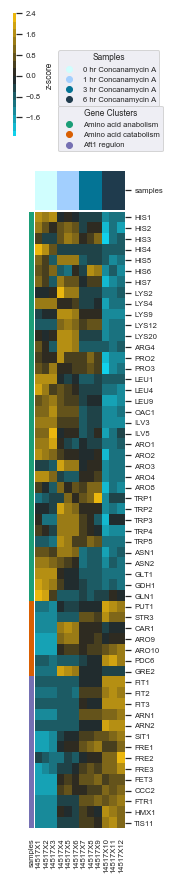

In [23]:
#Get genes of interest for heatmap
genes = pd.read_csv(__path__ + 'metadata/gene_list_v3.csv')
genes_info = genes[['gene_id','function']]
genes_info.columns = [0,1]

#Get common names for conversion
genes_common = genes[['gene_name','function']]
genes_common.columns = [0,1]

#Get dataframe of gene cohort of interest
df_plot = df_conA_scaled.loc[genes_info[0].tolist()]
print('Size of gene cohort data matrix:' + str(df_plot.shape))

#Rename gene ids to common names
labels = pd.Series(genes['gene_name'].values,index=genes['gene_id']).to_dict()
df_plot['name'] = df_plot.index.map(labels.get)
df_plot = df_plot.set_index('name')
del df_plot.index.name

#Set dictionary of gene color legend
gene_colors = {'Amino acid anabolism':'#1b9e77', 'Amino acid catabolism':'#d95f02', 'Aft1 regulon':'#7570b3'}

#Plot heatmap
xp.heatmap(df_plot, info_ch, sample_palette=colors, gene_palette=gene_colors,
    gene_info=genes_common, figsize=(2,15),
    row_cluster=False, col_cluster=False, font_scale=.7,
          cbar_kws={'label': 'z-score'})

#Format legends
import matplotlib
import matplotlib.pyplot

f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(gene_colors.values())[i]) for i in range(len(list(gene_colors.values())))]
first_legend = plt.legend(handles, list(gene_colors.keys()), bbox_to_anchor=(15, 0.25), loc=2, borderaxespad=0., title='Gene Clusters')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(colors.values())[i]) for i in range(len(list(colors.values())))]
plt.legend(handles_g, list(colors.keys()), bbox_to_anchor=(15, .7), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(__path__ + 'plots/gene_list_heatmap_final.pdf',dpi=1800,bbox_inches='tight')
plt.show()

### Cellular Iron Homeostasis GO Term

Size of gene cohort data matrix:(30, 12)


<Figure size 432x288 with 0 Axes>

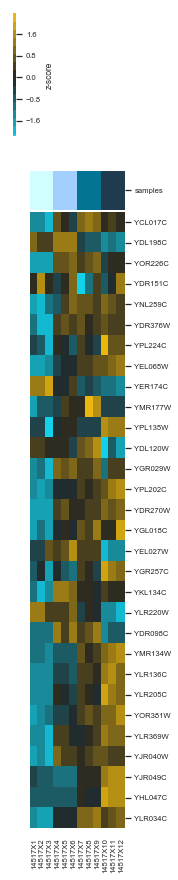

In [35]:
genes = pd.read_csv('/Users/jordan/Desktop/cellular_iron_ion_homeostasis_annotations.tsv', sep='\t', header = None)
genes = genes[0].tolist()
genes = list(set(genes))

#Get dataframe of gene cohort of interest
df_plot = df_conA_scaled.loc[genes]
print('Size of gene cohort data matrix:' + str(df_plot.shape))

#Plot heatmap
xp.heatmap(df_plot, info_ch, sample_palette=colors, 
     figsize=(2,15),
    row_cluster=False, col_cluster=False, font_scale=.7,
          cbar_kws={'label': 'z-score'})

plt.show()

Size of gene cohort data matrix:(4, 12)


<Figure size 432x288 with 0 Axes>

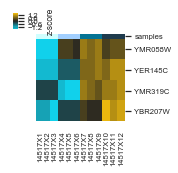

In [34]:
genes = pd.read_csv('/Users/jordan/Desktop/iron_ion_transmembrane_transport_annotations.txt', sep='\t', header = None)
genes = genes[0].tolist()
genes = list(set(genes))

#Get dataframe of gene cohort of interest
df_plot = df_conA_scaled.loc[genes]
print('Size of gene cohort data matrix:' + str(df_plot.shape))

#Plot heatmap
xp.heatmap(df_plot, info_ch, sample_palette=colors, 
     figsize=(2,2),
    row_cluster=False, col_cluster=False, font_scale=.7,
          cbar_kws={'label': 'z-score'})

plt.show()

Size of gene cohort data matrix:(24, 12)


<Figure size 432x288 with 0 Axes>

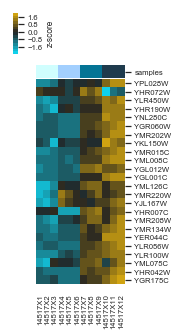

In [37]:
genes = pd.read_csv('/Users/jordan/Desktop/ergosterol_biosynthetic_process_annotations.txt', sep='\t', header = None)
genes = genes[0].tolist()
genes = list(set(genes))

#Get dataframe of gene cohort of interest
df_plot = df_conA_scaled.loc[genes]
print('Size of gene cohort data matrix:' + str(df_plot.shape))

#Plot heatmap
xp.heatmap(df_plot, info_ch, sample_palette=colors, 
     figsize=(2,5),
    row_cluster=False, col_cluster=False, font_scale=.7,
          cbar_kws={'label': 'z-score'})

plt.show()

### GO Term Analysis

<u><b>Perform differential expression analysis at timepoint 6 </b></u>
- Requires [xpresspipe](https://github.com/XPRESSyourself/XPRESSpipe) 
```
$ xpresspipe diffxpress -i ./deseq/conA_counts_6hr.tsv -s info_6h_conA.tsv --design time
```
- From output, kept genes with FDR < 0.01 & log<sub>2</sub>(FC) > 1 | log<sub>2</sub>(FC) < -1

<u><b>Perform statistical analysis of significant genes with GO terms </b></u>  
##### GO Term Analysis:
Test Type: Fisher's Exact    
Correction: Calculate False Discovery Rate   
Displaying only results for FDR P < 0.05   
GO Analysis was performed 30 Aug 2019, using PANTHER Overrepresentation Test v14.1 and Gene Ontology Version 2019-07-03
##### Post-processing for selecting GO terms:
- FDR < 0.01 for up-reg or FDR < 1E-25 for down-reg
- Actual / total > 0.2
   
##### Citations:   
Ashburner et al. Gene ontology: tool for the unification of biology. Nat Genet. May 2000;25(1):25-9.   
The Gene Ontology Consortium. The Gene Ontology Resource: 20 years and still GOing strong. Nucleic Acids Res. Jan 2019;47(D1):D330-D338.    
Mi H, Huang X, Muruganujan A, Tang H, Mills C, Kang D, Thomas PD. PANTHER version 11: expanded annotation data from Gene Ontology and Reactome pathways, and data analysis tool enhancements. Nucleic Acids Res. Jan 2017;45(D1):D183-D189.  